Enter CSV filename including '.csv' (must be in this directory): 2016_data_group1.csv
How many header rows should I skip? [0]: 1
Enter separation limit: 100
Calculated 67747 planes; 0 colinear triplets skipped.
Use all of the calculated planes to create density plots? (More planes takes longer.) [Y/n]: n
use a random subset of the calculated planes? (If no, then indicate starting index and ending index.) [Y/n]: n
Index start (0-based): 0
Index end: 30000
Method (exponential_kamb/linear_kamb/kamb/schmidt) [default = exponential_kamb]: 
Sigma for Kamb [default = 3.0]: 10
Max # poles to plot as dots [default = 2000]: 
Output image filename (jpg/png, blank=don’t save): 


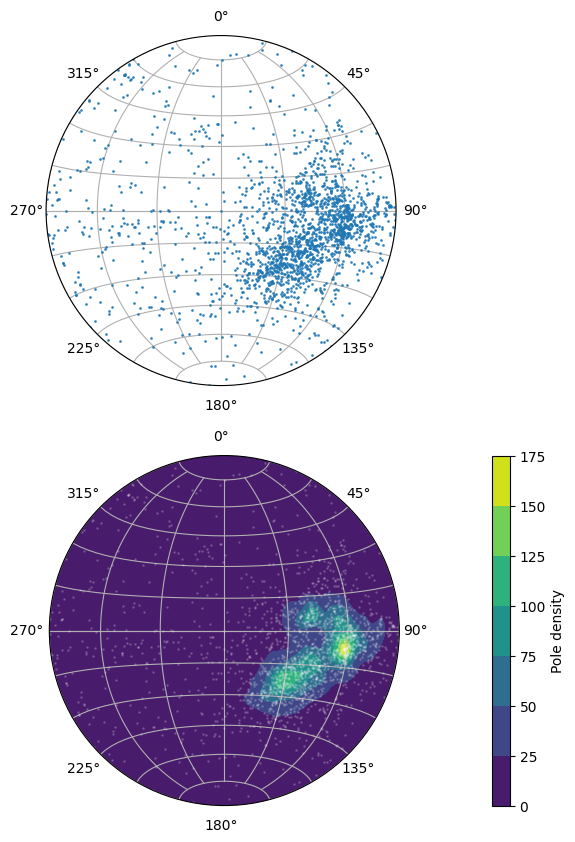

In [6]:
#!/usr/bin/env python3
!pip install mplstereonet
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import mplstereonet

def read_and_validate_csv():
    # 1) Ask for filename
    fname = input("Enter CSV filename including '.csv' (must be in this directory): ").strip()
    if not fname.lower().endswith(".csv") or not os.path.isfile(fname):
        sys.exit(f"ERROR: '{fname}' not found or not a .csv file.")
    # 2) Ask how many header rows to skip
    skip = int(input("How many header rows should I skip? [0]: ") or "0")
    df = pd.read_csv(fname, skiprows=skip)
    # 3) Validate exactly 3 columns
    if df.shape[1] != 3:
        sys.exit("ERROR: CSV must have exactly 3 columns (x, y, z).")
    df.columns = ["x","y","z"]
    return df

def calculate_planes(points, separation_limit):
    # unchanged from optimized version earlier, except added inline notes
    pts = np.asarray(points, dtype=float)
    n = len(pts)
    # build neighbor sets so we never test triples that already violate separation
    neighbors = [set() for _ in range(n)]
    for i in range(n):
        for j in range(i+1, n):
            if np.linalg.norm(pts[i]-pts[j]) <= separation_limit:
                neighbors[i].add(j)
                neighbors[j].add(i)
    planes = []
    colinear = []
    # --- Iterate only over index triples that respect the separation limit ---
    for i in range(n):
        for j in neighbors[i]:
            if j <= i: continue # ensure j > i
            # Only k that are neighbors of both i and j can form a valid triple
            common = neighbors[i].intersection(neighbors[j])
            for k in common:
                if k <= j: continue # ensure k > j
                p1,p2,p3 = pts[i],pts[j],pts[k]
                # Compute two edge vectors of the triangle
                v1 = p2-p1
                v2 = p3-p1
                # Cross product = normal vector (not yet unit)
                normal = np.cross(v1, v2)
                norm = np.linalg.norm(normal)
                if norm == 0:
                    # Points are colinear or coincident
                    colinear.append((tuple(p1),tuple(p2),tuple(p3)))
                else:
                    # Normalize to unit vector
                    normal /= norm
                    planes.append(tuple(normal))
    return planes, colinear

def extract_strike_dip(planes):
    # plane normal → (strike, dip)
    strikes, dips = [], []
    for nx,ny,nz in planes:
        # flip if down-facing
        if nz < 0:
            nx,ny,nz = -nx,-ny,-nz
        # dip
        dip = np.degrees(np.arctan2(np.hypot(nx,ny), nz))
        # strike dir
        dipdir = np.degrees(np.arctan2(nx, ny)) % 360.0
        strike = (dipdir - 90.0) % 360.0
        strikes.append(strike)
        dips.append(dip)
    return np.array(strikes), np.array(dips)

def plot_and_save(strike, dip, strike_sub, dip_sub):
    # 1) ask density params
    method = input("Method (exponential_kamb/linear_kamb/kamb/schmidt) [default = exponential_kamb]: ").strip() or "exponential_kamb"
    sigma  = float(input("Sigma for Kamb [default = 3.0]: ") or "3.0")
    # 2) ask how many subsample plotting points
    max_plot = int(input("Max # poles to plot as dots [default = 2000]: ") or "2000")
    # 3) ask output filename
    out = input("Output image filename (jpg/png, blank=don’t save): ").strip()
    # prepare subset for poles/planes overlay
    N = len(strike) # Fixed: Use len() instead of strike.size
    if N > max_plot:
        idx = np.random.choice(N, max_plot, replace=False)
        strike_sub = strike[idx]; dip_sub = dip[idx]
    # figure
    fig, (ax1,ax2) = plt.subplots(2,1, figsize=(10,10),
                                  subplot_kw={'projection':'stereonet'})
    # top: poles + planes
    ax1.pole(strike_sub, dip_sub, '.', ms=2, alpha=0.8)
    #ax1.plane(strike_sub, dip_sub, linewidth=0.5, alpha=0.4)
    ax1.grid(True)
    # bottom: density contour
    dens = ax2.density_contourf(
        strike, dip,
        measurement='poles',
        #gridsize=[36,18],        # unchanged default resolution
        method=method,
        sigma=sigma
    )
    ax2.pole(strike_sub, dip_sub, 'wo', ms=1, alpha=0.15)
    ax2.grid(True)
    fig.colorbar(dens, ax=ax2, label='Pole density', pad=0.12)
    if out:
        plt.savefig(out, dpi=300)
        print(f"→ Saved figure to {out}")
    plt.show()

def main():
    df = read_and_validate_csv()
    sep = float(input("Enter separation limit: "))
    pts = df[['x','y','z']].values
    planes, colinear = calculate_planes(pts, sep)
    print(f"Calculated {len(planes)} planes; {len(colinear)} colinear triplets skipped.")
    use_all = input("Use all of the calculated planes to create density plots? (More planes takes longer.) [Y/n]: ").strip().lower() or 'y'
    strikes, dips = extract_strike_dip(planes)
    if use_all.startswith('n'):
        random = input("use a random subset of the calculated planes? (If no, then indicate starting index and ending index.) [Y/n]: ").strip().lower() or 'y'
        if random.startswith('y'):
            subset_size = int(input("Enter subset size (must be smaller than total number of calculated planes): "))
            idx = np.random.choice(len(strikes), subset_size, replace=False) #fixed: use len(strikes)
            strikes = strikes[idx]
            dips    = dips[idx]
        else:
          lo = int(input("Index start (0-based): "))
          hi = int(input("Index end: "))
          strikes = strikes[lo:hi]
          dips    = dips[lo:hi]
    # now plot + save
    plot_and_save(strikes, dips, strikes, dips)


if __name__ == "__main__":
    main()
